### Put all import statement here 

In [1]:
import os
#force to use cpu in jupyter notebook, due to GPU memory allocation issue in jupypter
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import imageio
import matplotlib.pyplot as plot
import numpy as np
import seaborn as sns
from keras.utils.np_utils import to_categorical 
from IPython.display import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
%matplotlib inline

C:\Anaconda3\envs\DeepLearn\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Prepare data 
MNIST dataset has a good collection of handwritten digits. Train set has 60,000 rows of data and test set has 10,000 rows of data. The binary data is available at http://yann.lecun.com/exdb/mnist/. <br><br>
However, to demostrate the real-life situation where the input is a real image, we have downloaded the png images from this link https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz. It extracts the data from binary file and convert into 60,000 train images and 10,000 test images. The images are categorized according to their label

Now we are going to use imageio and read on the image. The sample_image is a 28*28 numpy array. To show the image is labelled correctly, we will use matplotlib to visualize the array

The shape of the sample image:  (28, 28)


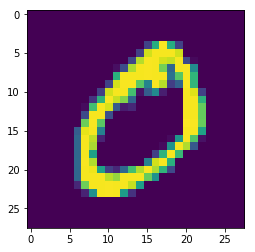

In [2]:
sample_image = imageio.imread('images/train/0/1.png')
print("The shape of the sample image: ", sample_image.shape)
g = plot.imshow(sample_image)
Image("images/train/0/1.png")

The real image and graph show that this digit is a 0, matched with its label. Now we need to create a method to read all images and its label into numpy. <br> We normalize the data from [0..255] to [0..1]. It will also help CNN to coverg faster. 

In [3]:
train_x = np.empty([60000,28,28])
train_y = np.empty([60000], dtype="int32")
test_x = np.empty([10000,28,28])
test_y = np.empty([10000], dtype="int32")

def store_image_to_train_test(index, is_train, image_array, label):
    if is_train:
        train_x[index] = image_array / 255
        train_y[index] = int(label)
    else:
        test_x[index] = image_array / 255
        test_y[index] = int(label)

def loop_train_test_image_file(is_train, parent_folder):
    index = 0
    for i in range (0,10):
        folder = parent_folder + "/" + str(i) + "/"
        for filename in os.listdir(folder):
            store_image_to_train_test(index, is_train, imageio.imread(folder + filename), i)
            index += 1
        print("Completed " + folder + ", accumulated " + str(index) + " images")

loop_train_test_image_file(True, "images/train")
loop_train_test_image_file(False, "images/test")

Completed images/train/0/, accumulated 5923 images
Completed images/train/1/, accumulated 12665 images
Completed images/train/2/, accumulated 18623 images
Completed images/train/3/, accumulated 24754 images
Completed images/train/4/, accumulated 30596 images
Completed images/train/5/, accumulated 36017 images
Completed images/train/6/, accumulated 41935 images
Completed images/train/7/, accumulated 48200 images
Completed images/train/8/, accumulated 54051 images
Completed images/train/9/, accumulated 60000 images
Completed images/test/0/, accumulated 980 images
Completed images/test/1/, accumulated 2115 images
Completed images/test/2/, accumulated 3147 images
Completed images/test/3/, accumulated 4157 images
Completed images/test/4/, accumulated 5139 images
Completed images/test/5/, accumulated 6031 images
Completed images/test/6/, accumulated 6989 images
Completed images/test/7/, accumulated 8017 images
Completed images/test/8/, accumulated 8991 images
Completed images/test/9/, accumu

Below charts show the distribution of class labels in training and test set. Both are them are nearly balanced 

Text(0.5,1,'Training set')

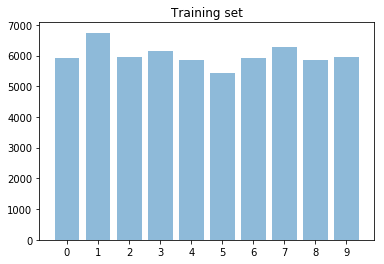

In [5]:
x_pos = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')
plot.bar(x_pos,  np.bincount(train_y), align='center', alpha=0.5)
plot.title('Training set')

Text(0.5,1,'Test set')

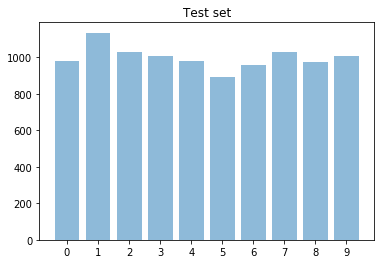

In [6]:
plot.bar(x_pos,  np.bincount(test_y), align='center', alpha=0.5)
plot.title('Test set')

Encode the labels by using one hot encoder. It will convert into 10 binary labels

In [7]:
train_y = to_categorical(train_y, num_classes = 10)
test_y = to_categorical(test_y, num_classes = 10)

Keras requires last dimension to represent the channel. For RGB there will be 3 channels. MNIST is a grayscale so it uses only one channel. 

In [7]:
train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)

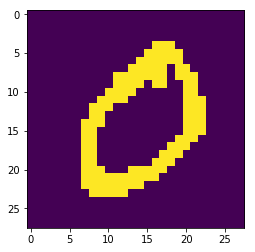

In [10]:
g = plot.imshow(train_x[0][:,:,0])

In [10]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state=2)

# 2. Modeling

Before go into CNN, data augmentation is a key idea to avoid overfitting problem. We can transform our data and make the existing dataset even larger. The purpose is to alter the training data with minor tweeks to simulate the real-life sitatuion because each person may write the same digit in different pattern. <br> <br>
<b>For data augmentation, we choosed apply below options randomly to some training images : </b><br/>
Randomly Zoom by 15%  <br>
Randomly rotates by 10 degrees <br> 
Randomly shift images horizontally by 15% of the width <br>
Randomly shift images vertically by 15% of the height<br>

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=10,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  
        vertical_flip=False)  


datagen.fit(train_x)

Now we going to define our CNN model. <br> <br>
<b>1st and 2nd layer</b>: Convolutional layer (Conv2D). They are like a set of learnable filters. Each filter (or kernel) is an integral component of the layered architecture. In these layers, the kernel size is (5,5). It involves taking patches from the input images size (28x28) equal to that of the kernel (5x5) and convolving between the value in the patch and those in the kernal matrix.<br> <br>
<b>3rd layer</b>: Downsampling (pooling) layer. It looks at the 2 neighboring pixels and picks the maximal value. Mainly to reduce the feature map dimensionality for computational efficiency, which can in turn improve actual performance. 
<br> <br>
<b>4th layer</b>: Dropout is a regularization technique to prevent overfitting<br> <br>
<b>5th and 6th layer</b>: Convolutional layer with 64 bits filter and 3x3 kernal size<br> <br>
<b> 7th layer </b>: Another downsampling (pooling) layer <br> <br>
<b> 8th layer </b>: Another dropout layer  <br><br>
<b> 9th layer </b>: Flatten layer. It is the process of converting all the resultant 2 dimensional arrays into a single long continuous linear vector.   <br><br>
<b> 10th layer </b>: Dense layer for classification  <br><br>
<b> 11th layer </b>: Another dropout layer  <br><br>
<b> 12th layer </b>: Dense layer for classification, with softmax activation function  <br><br>

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Next thing is to defines an optimizer, a score function and a loss function. RMSprop is a very effective optimizer. We use "categorical_crossentropy" as our loss function and "accuracy" as our score function

In [13]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Annealer help to reduce learning rate to reach the global minimum of the loss function

In [14]:
annealer = ReduceLROnPlateau(monitor='val_acc', 
                             patience=3, 
                             verbose=1, 
                             factor=0.5, 
                             min_lr=0.00001)

Let run our model and train it! 

In [ ]:
history = model.fit_generator(datagen.flow(train_x,train_y, batch_size=86),
                              epochs = 40, validation_data = (val_x,val_y),
                              verbose = 2, steps_per_epoch=train_x.shape[0] // 86
                              , callbacks=[annealer])

Epoch 1/1


In jupyter notebook, it has issue in GPU memory allocation. Training on CPU will take much longer time. We can run the py file seperately, train the model save it and load the model at here

In [16]:
model = load_model("mnist.h5")

# 3. Evaluate the model
Let see the accuracy and confusion matrix

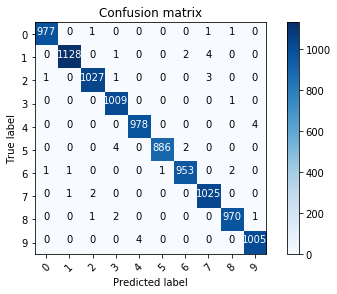

In [23]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = np.arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.tight_layout()
    plot.ylabel('True label')
    plot.xlabel('Predicted label')

# Predict the values from the validation dataset
pred_y = model.predict(test_x)
# Convert predictions classes to one hot vectors 
pred_classes_y = np.argmax(pred_y,axis = 1) 
# Convert validation observations to one hot vectors
actual_y = np.argmax(test_y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(actual_y, pred_classes_y) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [25]:
accuracy_score(actual_y, pred_classes_y) 

0.9958

Check the predicted label for one of the example

Predicted:  0


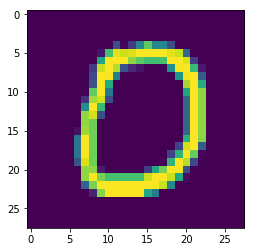

In [31]:
print("Predicted: ", pred_classes_y[0])
plot.imshow(test_x[0][:,:,0])